In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import pickle as pkl
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

In [5]:
def load_data_from_pfile(file_path):
    with open(file_path, 'rb') as pfile:
        sample_data = pkl.load(pfile)
    return sample_data

In [6]:
class PHMDataset(Dataset):
    '''
    PHM IEEE 2012 Data Challenge Training data set (6 different Mechanical Bearings data)
    '''
    def __init__(self, pfiles=[]):
        self.data = {'x': [], 'y': []}
        for pfile in pfiles:
            _data = load_data_from_pfile(pfile)
            self.data['x'].append(_data['x'])
            self.data['y'].append(_data['y'])
        self.data['x'] = np.concatenate(self.data['x'])
        self.data['y'] = np.concatenate(self.data['y'])[:,np.newaxis]

    def __len__(self):
        return self.data['x'].shape[0]

    def __getitem__(self, i):
        sample = {'x': torch.from_numpy(self.data['x'][i]), 'y': torch.from_numpy(self.data['y'][i])}
        return sample

In [7]:
pkzfiles_path = '/content/drive/MyDrive/Colab Notebooks/CNN-LSTM/ieee-phm-2012-data-challenge-dataset-master/Learning_set/'

train_pfiles = [pkzfiles_path+'bearing1_1_train_data.pkz', pkzfiles_path+'bearing1_2_train_data.pkz']

val_pfiles = [pkzfiles_path+'bearing1_1_val_data.pkz', pkzfiles_path+'bearing1_2_val_data.pkz']

In [8]:
train_dataset = PHMDataset(pfiles=train_pfiles)
val_dataset = PHMDataset(pfiles=val_pfiles)
print(len(train_dataset), len(val_dataset))

3307 367


In [9]:
train_batch_size = 32
val_batch_size = 32

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, num_workers=1)

In [11]:
def conv_bn_relu(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', batch_norm=True):
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias, padding_mode=padding_mode)
    nn.init.xavier_uniform_(conv.weight)
    relu = nn.ReLU()
    if batch_norm:
        return nn.Sequential(
            conv,
            nn.BatchNorm2d(out_channels),
            relu
        )
    else:
        return nn.Sequential(
            conv,
            relu
        )

In [12]:
class CNN_FP(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_bn_relu(2, 16, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = conv_bn_relu(16, 32, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = conv_bn_relu(32, 64, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv4 = conv_bn_relu(64, 128, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8192, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.2)

    def forward(self, x):
        # input shape = [Nx2x128x128]
        x = self.conv1(x) # [Nx16x128x128]
        x = self.pool1(x) # [Nx16x64x64]
        x = self.conv2(x) # [Nx32x64x64]
        x = self.pool2(x) # [Nx32x32x32]
        x = self.conv3(x) # [Nx64x32x32]
        x = self.pool3(x) # [Nx64x16x16]
        x = self.conv4(x) # [Nx128x16x16]
        x = self.pool4(x) # [Nx128x8x8]
        x = self.flatten(x) # [Nx8192] {128*8*8=8192} (N => batch size, 128 => no. of channels, 8*8 => height of image*width of image)
        x = self.fc1(x) # [Nx256]
        # x = self.dropout1(x) # apply dropout
        x = nn.ReLU()(x) # apply ReLU activation
        x = self.fc2(x) # [Nx128]
        # x = self.dropout2(x) # apply dropout
        x = nn.ReLU()(x) # apply ReLU activation
        x = self.fc3(x) # final fully connected layer (or) final linear layer [Nx1] -> output is probability of fault
        return x

In [13]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Declaring a variable "device" which will hold the device(i.e. either GPU or CPU) we are
                                                                      #training the model on
print(device)
device

cuda:0


device(type='cuda', index=0)

In [14]:
model = CNN_FP().to(device)

In [15]:
criterion = nn.MSELoss(reduction='sum')

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

In [17]:
multistep_lr_sch = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.1, last_epoch=-1, verbose=False)

In [18]:
def train_epoch(model, dataloader, criterion, optimizer):
    total_loss = 0
    num_of_samples = 0
    model.train()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y'].to(device, dtype=torch.float)

        optimizer.zero_grad()
        y_prediction = model(x)
        loss = criterion(y_prediction, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.cpu().item()
        num_of_samples += x.shape[0]
    return total_loss/num_of_samples

In [19]:
def eval(model, dataloader, criterion):
    total_loss = 0
    num_of_samples = 0
    model.eval()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y'].to(device, dtype=torch.float)

        with torch.no_grad():
            y_prediction = model(x)
            loss = criterion(y_prediction, y)

        total_loss += loss.cpu().item()
        num_of_samples += x.shape[0]
    return total_loss/num_of_samples

In [20]:
max_epochs = 30

loss_vals = []
for epoch in range(max_epochs):
    train_loss = train_epoch(model, train_dataloader, criterion, optimizer)
    val_loss = eval(model, val_dataloader, criterion)
    multistep_lr_sch.step()
    loss_vals.append([train_loss, val_loss])
    print('{0}/{1}: train_loss = {2:.4f}, val_loss = {3:.4f}'.format(epoch+1, max_epochs, train_loss, val_loss) )

1/30: train_loss = 0.6821, val_loss = 0.0271
2/30: train_loss = 0.0220, val_loss = 0.0481
3/30: train_loss = 0.0169, val_loss = 0.0135
4/30: train_loss = 0.0117, val_loss = 0.0080
5/30: train_loss = 0.0114, val_loss = 0.0124
6/30: train_loss = 0.0074, val_loss = 0.0165
7/30: train_loss = 0.0069, val_loss = 0.0069
8/30: train_loss = 0.0053, val_loss = 0.0095
9/30: train_loss = 0.0051, val_loss = 0.0039
10/30: train_loss = 0.0051, val_loss = 0.0031
11/30: train_loss = 0.0028, val_loss = 0.0028
12/30: train_loss = 0.0027, val_loss = 0.0027
13/30: train_loss = 0.0025, val_loss = 0.0035
14/30: train_loss = 0.0026, val_loss = 0.0028
15/30: train_loss = 0.0026, val_loss = 0.0027
16/30: train_loss = 0.0024, val_loss = 0.0026
17/30: train_loss = 0.0024, val_loss = 0.0032
18/30: train_loss = 0.0026, val_loss = 0.0029
19/30: train_loss = 0.0023, val_loss = 0.0029
20/30: train_loss = 0.0024, val_loss = 0.0037
21/30: train_loss = 0.0021, val_loss = 0.0027
22/30: train_loss = 0.0021, val_loss = 0.00

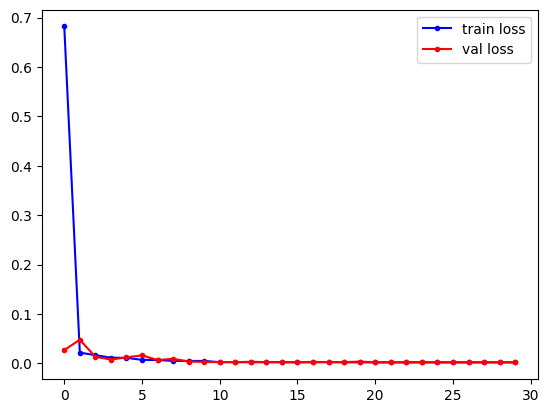

In [21]:
plt.plot(range(max_epochs), [l[0] for l in loss_vals], 'b.-', label='train loss')
plt.plot(range(max_epochs), [l[1] for l in loss_vals], 'r.-', label='val loss')
plt.legend()
plt.show()

In [22]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/CNN-LSTM/cnn_model1_train1+2.pth')

In [23]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/CNN-LSTM/cnn_model1_train1+2.pth'))

<All keys matched successfully>

In [24]:
def model_inference_helper(model, dataloader):
    results = {'labels':[], 'predictions':[]}
    model.eval()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y']

        with torch.no_grad():
            y_prediction = model(x)

        results['labels'] += y.squeeze().tolist()
        results['predictions'] += y_prediction.cpu().squeeze().tolist()
    return results

In [25]:
def sort_results(results):
    ind = [i[0] for i in sorted(enumerate(results['labels']), key=lambda x: x[1])]
    results['labels'] = [results['labels'][i] for i in ind]
    results['predictions'] = [results['predictions'][i] for i in ind]
    return results

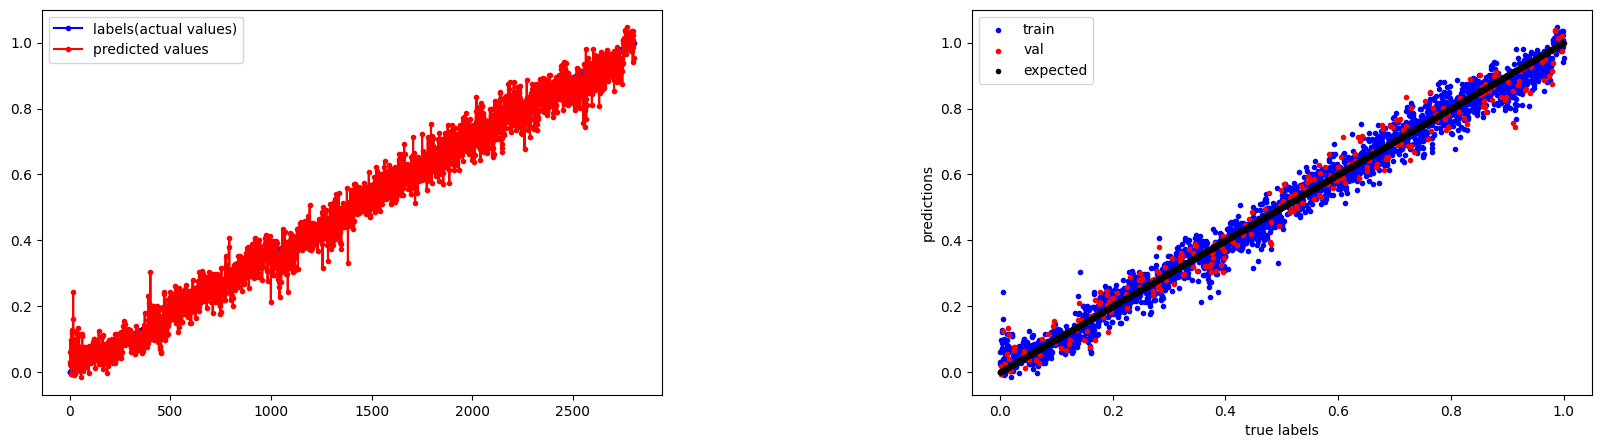

In [26]:
train1_pfiles = [pkzfiles_path+'bearing1_1_train_data.pkz']
val1_pfiles = [pkzfiles_path+'bearing1_1_val_data.pkz']
train1_dataset = PHMDataset(pfiles=train1_pfiles)
val1_dataset = PHMDataset(pfiles=val1_pfiles)

train1_dataloader = DataLoader(train1_dataset, batch_size=64, shuffle=False, num_workers=1)
val1_dataloader = DataLoader(val1_dataset, batch_size=64, shuffle=False, num_workers=1)

train1_results = model_inference_helper(model, train1_dataloader)
val1_results = model_inference_helper(model, val1_dataloader)
results = {'labels': train1_results['labels']+val1_results['labels'], 'predictions': train1_results['predictions']+val1_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train1_results['labels'], train1_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val1_results['labels'], val1_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

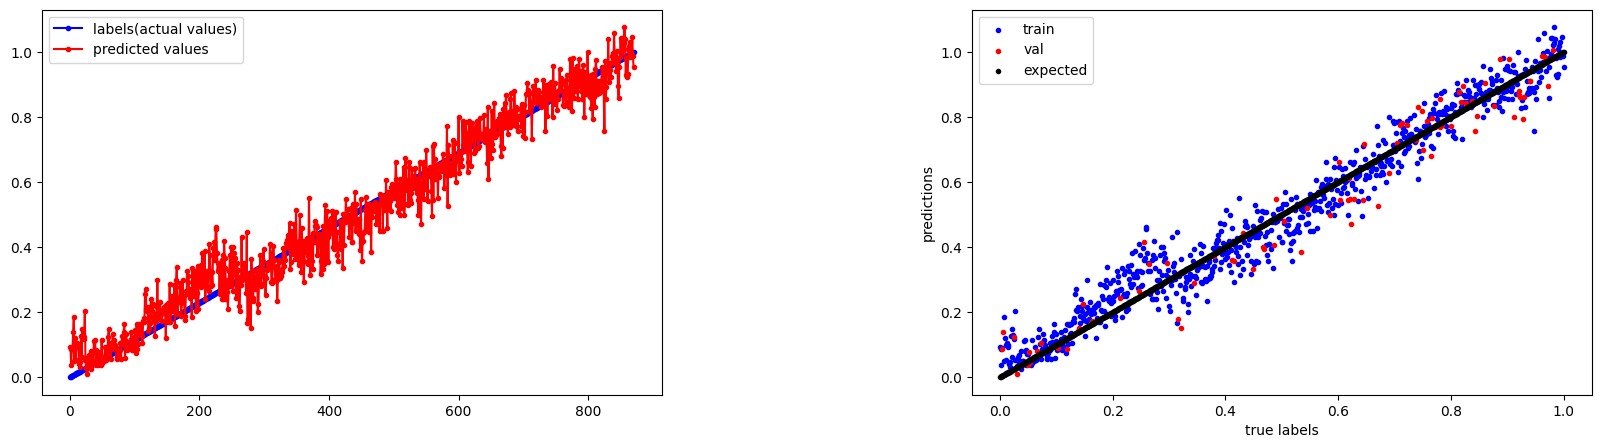

In [27]:
train1_pfiles = [pkzfiles_path+'bearing1_2_train_data.pkz']
val1_pfiles = [pkzfiles_path+'bearing1_2_val_data.pkz']
train1_dataset = PHMDataset(pfiles=train1_pfiles)
val1_dataset = PHMDataset(pfiles=val1_pfiles)

train1_dataloader = DataLoader(train1_dataset, batch_size=64, shuffle=False, num_workers=1)
val1_dataloader = DataLoader(val1_dataset, batch_size=64, shuffle=False, num_workers=1)

train1_results = model_inference_helper(model, train1_dataloader)
val1_results = model_inference_helper(model, val1_dataloader)
results = {'labels': train1_results['labels']+val1_results['labels'], 'predictions': train1_results['predictions']+val1_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train1_results['labels'], train1_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val1_results['labels'], val1_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()